# Assignment 1: Graph Pathfinding with Genetic Algorithms

In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

## Task 1: Shortest path between 2 nodes

Here we are creating a few graphs that will serve as examples. Graph are represented like this: first a specified number of nodes and the list of connections (*Node A*, *Node B*, *Distance*).   
The goal of the first task is to find the shortest distances between two nodes. In addition to the graph itself, the input data should also include the start and end nodes.   
Choose and implement a suitable fitness function and run a genetic algorithm to find the shortest path in a given graph provided as a .txt file.   
Experiment with different mutation/crossover functions and other GA parameters(population size, selection, etc.) and try to find the optimal configuration of the algorithm.

In [2]:
# save graph
with open("graphs/g5.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g5.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)

3
   A  B  w
0  1  2  1
1  2  3  1
2  3  1  1


In [3]:
start = 1
end = 3

# gene space so nodes grafa, a brez start in end - dodala 0, za direktne povezave
gene_space = [i for i in range(0, n+1) if i != start and i != end]
print(gene_space)

[0, 2]


In [4]:
INVALID = -1e12

def pathLength(pygad_instance, path, solution_index):
#def length(path):
    path_real = []
    seen = set()

    for x in path:
        if x != 0 and x not in seen:
            path_real.append(x)
            seen.add(x)
    path_real.append(end)

    N = len(path_real)
    dist = 0
    prev = start

    for i in range(N): 
        node = path_real[i]

        w = graph.loc[(graph['A'] == prev) & (graph['B'] == node), 'w']
        if w.empty:
            return INVALID    # punish not available path
        
        dist += w.values[0]
        prev = node

    return -dist

#length([3])  # bi pomenilo pot 1->3->4

In [5]:
ga_instance = pygad.GA(fitness_func = pathLength,
                       num_generations=100,    #<- kasneje za probat
                       num_parents_mating=10,
                       sol_per_pop=50,
                       num_genes=(n-2), # fixed length 
                       gene_space=gene_space,
                       gene_type=int,
                      )

ga_instance.run()

c:\Users\tases\miniconda3\envs\intelsys\Lib\site-packages\pygad\pygad.py:733: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(


In [6]:
#solution, solution_fitness, solution_idx = ga_instance.best_solution()
#print(-solution_fitness)
ga_instance.best_solution()

(array([2]), np.float64(-2.0), np.int64(0))

c:\Users\tases\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


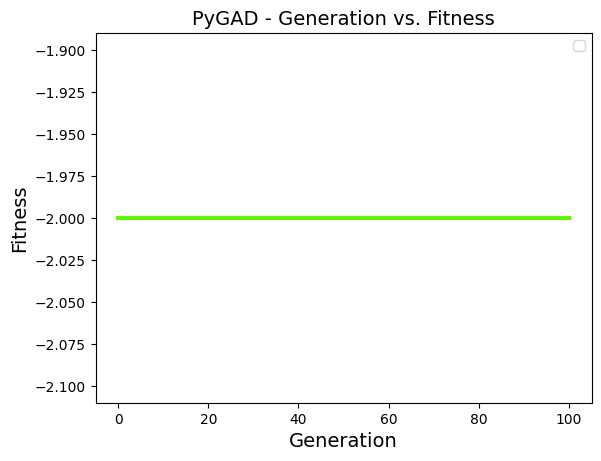

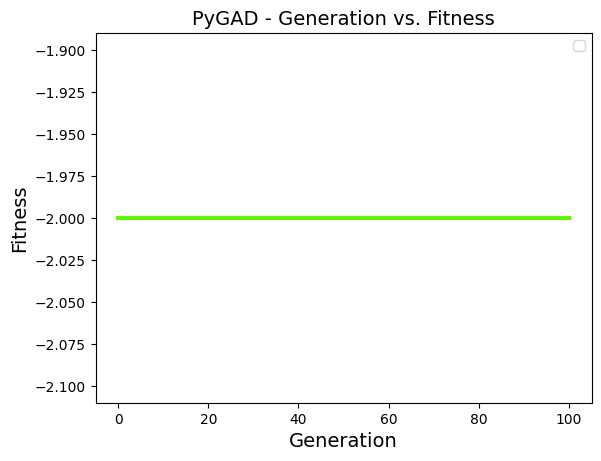

In [7]:
ga_instance.plot_fitness()

## Task 2: Shortest path between multiple nodes    
The goal of the second task is to update the GA from Task 1 with the ability to follow a path consisting of multiple nodes. Your GA should receive a sequence of N target nodes A, B, C,...N and return the shortest path that follows the given node order. Paths that do not visit every target node or paths that visit the target nodes in the incorrect order are no longer valid.    
Note that your solutions may now need to visit a single node multiple times (for example, to backtrack through a graph)    
In addition, improve your GA using crossover and mutation functions. Since the task now contains strict requirements you can implement those constraints into crossover and mutation functions and into starting population.

In [8]:
# target sequence
sequence = [1,2,3]

In [9]:
# here i changes that numer of genes = n, so the start and end nodes are included in fitness function

def pathLength_multipleNodes(pygad_instance, path, solution_index):
    # Calculate path length
    it = 0
    dist = 0

    for i in range(len(path)-1): 
        node1, node2 = path[i], path[i+1]
        if(node1 == node2 or node1 == 0): continue

        w = graph.loc[(graph['A'] == node1) & (graph['B'] == node2), 'w']
        if w.empty:
            return INVALID
        
        dist += w.values[0]

        if(node1 == sequence[it]): it += 1
        if(it == len(sequence)): return -dist

    if(path[-1] == sequence[it]): return -dist
    return INVALID


In [10]:
# intial population with constraints
def creating_init_pop(k):
    genom_len = k*n
    pop = []

    for _ in range(50):   # v oklepaju solutions per population
        # all the nodes we can add
        full_gene_space = [node for node in range(1, n+1)]
        number_of_nodes_to_insert = genom_len - len(sequence)      # je odvisno od num_genes

        # we decide on which indices we will insert random nodes into original sequence
        # we cannot insert them in [0] and [n-1] position (start and end)

        # list of indices on which we are going to insert new nodes
        positions = []

        # list of indices we can choose from
        possible_indices = list(range(genom_len))

        for _ in range(number_of_nodes_to_insert):
            # random choice of possible indices
            idx = np.random.choice(possible_indices)
            # we remove it from options
            possible_indices.remove(idx)
            # add to positions
            positions.append(idx)
        
        # all thats left is to build our startion population 
        # in indices from position we put a random node from full gene space

        # building process :)
        pop_individual = [-1] * genom_len   # list of n elements with value -1

        for x in positions:
            pop_individual[x] = np.random.choice(full_gene_space)
        
        it = 0
        for i in range(genom_len):
            if pop_individual[i] == -1:
                pop_individual[i] = sequence[it]
                it += 1

        # moja logika pravi, da bi moglu bit ok
        pop_individual = np.array(pop_individual)
        pop.append(pop_individual)
    
    #print(pop)
    return pop


In [11]:
# crossover function with those constraints

def custom_crossover(parents, offspring_size, ga_instance):
    offspring = []

    # offspring_size is a touple of 2 numbers: (the offspring size, number of genes)
    size_of_offspring, number_of_genes = offspring_size

    parents_size = len(parents)

    for i in range(size_of_offspring):
        # randomly choose 2 parents
        parent_indices = np.random.choice(parents_size, 2, replace=False)
        parent1 = parents[parent_indices[0]]
        parent2 = parents[parent_indices[1]]

        # now we have two random parents we chose for mating
    
        # idea: we traverse both parents and save possible points for crossovers
        # then we randomly select a point for crossover from the available points

        available_points_for_crossover = []

        # iterating over sequence
        it1 = 0
        it2 = 0

        for pos in range(0, number_of_genes):
            if it1 == it2:
                available_points_for_crossover.append(pos)
            if it1 < len(sequence) and parent1[pos] == sequence[it1]:
                it1 += 1
            if it2 < len(sequence) and parent2[pos] == sequence[it2]:
                it2 += 1
        
        chosen_crossover_point = np.random.choice(available_points_for_crossover, 1, replace=False)

        # combine parents to get child
        individual_offspring = np.concatenate([parent1[:chosen_crossover_point[0]], parent2[chosen_crossover_point[0]:]])

        offspring.append(individual_offspring)


    return np.array(offspring)

In [12]:
# druga verzija crossover funkcije, ni potrebe po popravljanju
def custom_crossover_ver2(parents, offspring_size, ga_instance):
    offspring = []

    # offspring_size is a touple of 2 numbers: (the offspring size, number of genes)
    size_of_offspring, number_of_genes = offspring_size

    parents_size = len(parents)

    for i in range(size_of_offspring):
        # randomly choose 2 parents
        parent_indices = np.random.choice(parents_size, 2, replace=False)
        parent1 = parents[parent_indices[0]]
        parent2 = parents[parent_indices[1]]

        # now we have two random parents we chose for mating
    
        # idea: we traverse both parents and save possible points for crossovers
        # then we randomly select a point for crossover from the available points 
        
        # idea: we save the first instance of sequence members - the indices on parent1
        # we save the last instances of sequence occurence - parent2
        # and then we have to somehow traverse this
        
        seq_ind1 = []
        it = 0
        for k in range (parents_size):
            if parent1[k] == sequence[it]:
                seq_ind1.append(k)
                it += 1
            if it == len(sequence): 
                break
        seq_ind2 = []
        it = len(sequence)-1
        for k in range(parents_size - 1, -1, -1):
            if parent2[k] == sequence[it]:
                seq_ind2.append(k)
                it -= 1
            if it == -1: 
                break
        
        seq_ind2 = seq_ind2[::-1]
        
        avail_points = set()
        if len(seq_ind1) == len(sequence) and len(seq_ind2) == len(sequence):

            for k in range(len(sequence)):
                if seq_ind2[k] >= seq_ind1[k]:
                    for j in range(seq_ind1[k], seq_ind2[k]+1):
                        avail_points.add(j)
        
        
        available_points_for_crossover = list(avail_points)
        if available_points_for_crossover :
            chosen_crossover_point = np.random.choice(available_points_for_crossover, 1, replace=False)

            # combine parents to get child
            individual_offspring = np.concatenate([parent1[:chosen_crossover_point[0]], parent2[chosen_crossover_point[0]:]])
        else : 
            individual_offspring = parent1
        offspring.append(individual_offspring)


    return np.array(offspring)

In [13]:
# mutation function with the same constraints
def custom_mutation(offspring, ga_instance):
    # after crossover, the offspring is handed to mutation
    
    # idea: swap two genes - not if they are both in sequence

    for offspring_individual in offspring:

        length = len(offspring_individual)

        swap_points = []
        it = 0


        for i in range(0, length-1):

            if offspring_individual[i] not in sequence:
                swap_points.append(i)

            if it < len(sequence)-1 and offspring_individual[i] == sequence[it]:
                it += 1       

        if swap_points:
            chosen_swap_point = np.random.choice(swap_points)
            offspring_individual[chosen_swap_point], offspring_individual[chosen_swap_point+1] = offspring_individual[chosen_swap_point+1], offspring_individual[chosen_swap_point]      

    return offspring

In [14]:
# creating a new population everytime i run GA
k = 2
init_pop = creating_init_pop(k)
print(init_pop)

ga_instance = pygad.GA(fitness_func=pathLength_multipleNodes,
                       num_generations=200,
                       num_parents_mating=5,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(n*k), # tried with n
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation,
                      )

ga_instance.run()

[array([3, 2, 1, 2, 2, 3]), array([3, 1, 1, 2, 3, 1]), array([1, 2, 2, 3, 2, 3]), array([1, 2, 3, 3, 2, 1]), array([1, 1, 2, 1, 3, 1]), array([1, 3, 2, 2, 3, 3]), array([1, 2, 2, 3, 3, 3]), array([1, 1, 2, 2, 1, 3]), array([1, 1, 2, 3, 1, 2]), array([1, 1, 2, 3, 2, 3]), array([1, 1, 2, 2, 3, 1]), array([1, 1, 1, 2, 3, 3]), array([1, 1, 2, 3, 2, 3]), array([2, 1, 2, 2, 2, 3]), array([1, 2, 1, 2, 3, 3]), array([3, 1, 3, 2, 3, 3]), array([2, 2, 1, 2, 3, 1]), array([3, 1, 1, 3, 2, 3]), array([1, 3, 1, 1, 2, 3]), array([1, 2, 2, 3, 2, 2]), array([1, 1, 1, 2, 2, 3]), array([2, 1, 2, 1, 3, 2]), array([1, 2, 1, 2, 3, 2]), array([2, 1, 2, 3, 3, 1]), array([1, 1, 3, 2, 2, 3]), array([1, 2, 3, 2, 3, 1]), array([1, 1, 2, 3, 3, 3]), array([1, 3, 3, 2, 2, 3]), array([1, 2, 3, 3, 2, 1]), array([1, 1, 2, 2, 2, 3]), array([1, 2, 3, 3, 3, 3]), array([1, 2, 1, 3, 3, 3]), array([1, 1, 1, 1, 2, 3]), array([1, 2, 3, 2, 3, 3]), array([1, 2, 3, 1, 1, 3]), array([1, 3, 2, 3, 1, 3]), array([1, 2, 2, 3, 2, 2]), 

In [15]:
ga_instance.best_solution()

(array([1, 1, 2, 3, 3, 3]), np.float64(-2.0), np.int64(0))

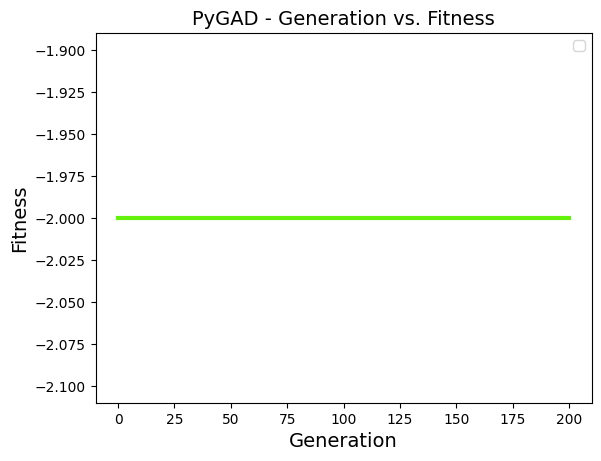

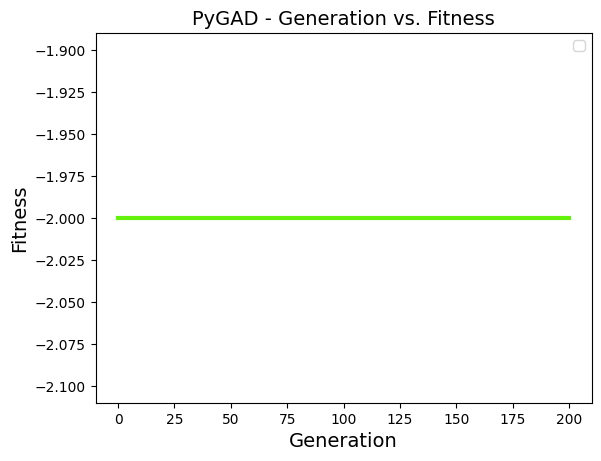

In [16]:
ga_instance.plot_fitness()

In [17]:
with open("graphs/g3.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g3.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)

12
     A   B  w
0    1   4  7
1    1   7  9
2    1   9  4
3    1  11  4
4    2   1  3
..  ..  .. ..
66  12   1  2
67  12   6  3
68  12   9  3
69  12  10  4
70  12  11  7

[71 rows x 3 columns]


In [55]:
sequence = [1, 4, 5, 9, 12]

gene_space = [i for i in range(0, n+1) if i != start and i != end]


k = 1
init_pop = creating_init_pop(k)
#print(init_pop)

ga_instance = pygad.GA(fitness_func=pathLength_multipleNodes,
                       num_generations=400,
                       num_parents_mating=5,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(n*k),
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=custom_crossover_ver2,
                       mutation_type=custom_mutation,
                      )

ga_instance.run()

In [56]:
ga_instance.best_solution()

(array([ 1,  4,  5,  9, 12, 11,  4,  4, 11, 11,  3,  8]),
 np.float64(-29.0),
 np.int64(0))

c:\Users\tases\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


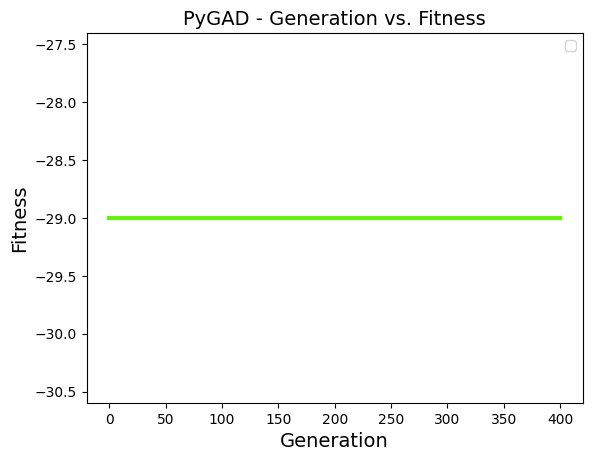

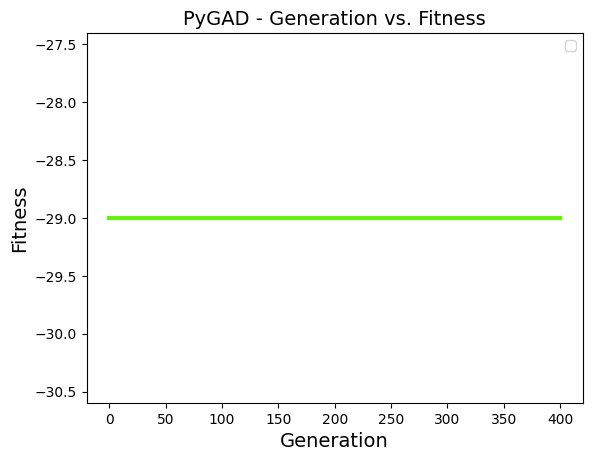

In [57]:
ga_instance.plot_fitness()

In [58]:
gene_space = [i for i in range(0, n+1) if i != start and i != end]


k = 1
init_pop = creating_init_pop(k)
#print(init_pop)

ga_instance = pygad.GA(fitness_func=pathLength_multipleNodes,
                       num_generations=400,
                       num_parents_mating=5,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(n*k),
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation,
                      )

ga_instance.run()

In [59]:
ga_instance.best_solution()

(array([ 1,  4,  3,  5,  5,  9, 12, 12,  9, 11, 11, 11]),
 np.float64(-25.0),
 np.int64(0))

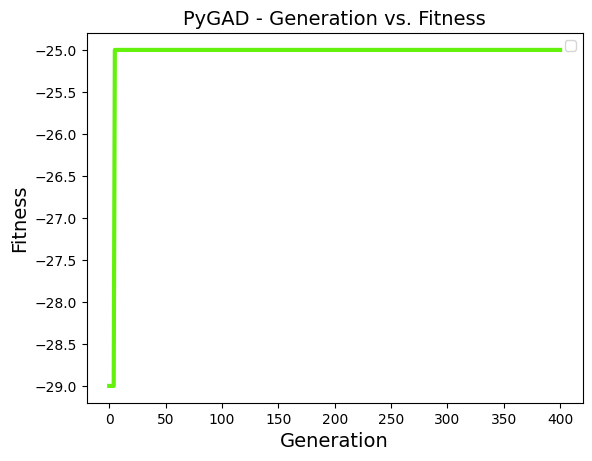

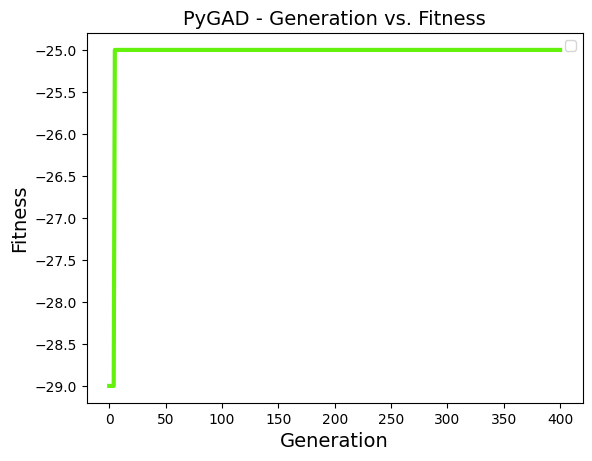

In [60]:
ga_instance.plot_fitness()

# Task 3

In [94]:
# save graph
with open("graphs/g1.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g1.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)


# Sem spremenila graf, da ima vse povezave -> manj INVALID returnov zaradi cen povezav

4
    A  B  w
0   1  2  4
1   1  3  2
2   1  4  3
3   2  1  3
4   2  4  7
5   2  3  8
6   3  4  1
7   3  2  5
8   3  1  1
9   4  2  1
10  4  3  2
11  4  1  1


In [95]:
k = 2
m = 3
agent_len = n*k
numAgents = m

sequence = [1,2,4]

gene_space = [i for i in range(1, n+1)]



In [96]:
# genom [3,3] - pomeni da čaka na 3
def creating_init_pop(n, agent_len, numAgents):
    pop = []

    full_gene_space = [node for node in range(1, n+1)]
    number_of_nodes_to_insert = agent_len - len(sequence)
    possible_indices = list(range(agent_len))

    for _ in range(50):   # v oklepaju solutions per population
        genoms = np.zeros(agent_len * numAgents)
        ix = 0

        # we repeat the same process but for each agent
        for _ in range(numAgents):
            indices = possible_indices.copy()
            positions = []
            
            for _ in range(number_of_nodes_to_insert):
                idx = np.random.choice(indices)
                indices.remove(idx)
                positions.append(idx)


            # building process :)
            agent = [-1] * agent_len   # list of n elements with value -1

            for x in positions:
                agent[x] = np.random.choice(full_gene_space)
            
            it = 0
            for i in range(agent_len):
                if agent[i] == -1:
                    genoms[ix] = sequence[it]
                    it += 1
                else:
                    genoms[ix] = agent[i]
                ix += 1
            
        pop.append(genoms)
    
    return pop

In [97]:
def ensure_sequence_subsequence(agent_arr, sequence):
    arr = agent_arr.tolist()
    seq = sequence

    # find longest prefix of sequence already matched
    si = 0
    for x in arr:
        if si < len(seq) and x == seq[si]:
            si += 1
    
    # if full sequence already present → return
    if si == len(seq):
        return np.array(arr, dtype=int)

    # otherwise, insert missing sequence elements (in the right order)
    for k in range(si, len(seq)):
        # Insert missing seq[k] at a random position AFTER the previous inserted element
        # but before the end of the list.
        insert_pos = np.random.randint(0, len(arr))
        arr.insert(insert_pos, seq[k])
        # to keep same length, remove last element
        arr.pop()

    return np.array(arr, dtype=int)



In [98]:
def crossover_task3(parents, offspring_size, ga_instance):
    offspring = []
    
    size_of_offspring, number_of_genes = offspring_size

    parents_size = len(parents)



    for i in range(size_of_offspring):
        # randomly choose 2 parents
        parent_indices = np.random.choice(parents_size, 2, replace=False)
        parent1 = parents[parent_indices[0]]
        parent2 = parents[parent_indices[1]]


        individual_offspring = np.array([], dtype=int)
        # now we have two random parents we chose for mating
    
        # idea: we traverse both parents and save possible points for crossovers
        # we do a crossover for each agent - so we save points for each agent
        # then we randomly select a point for crossover from the available points for each agent
        for agent_id in range(numAgents):

            seq_ind1 = []
            it = 0
            for k in range (parents_size):
                if parent1[k] == sequence[it]:
                    seq_ind1.append(k)
                    it += 1
                if it == len(sequence): 
                    break
            seq_ind2 = []
            it = len(sequence)-1
            for k in range(parents_size - 1, -1, -1):
                if parent2[k] == sequence[it]:
                    seq_ind2.append(k)
                    it -= 1
                if it == -1: 
                    break
            
            seq_ind2 = seq_ind2[::-1]
            
            avail_points = set()
            if len(seq_ind1) == len(sequence) and len(seq_ind2) == len(sequence):

                for k in range(len(sequence)):
                    if seq_ind2[k] >= seq_ind1[k]:
                        for j in range(seq_ind1[k], seq_ind2[k]+1):
                            avail_points.add(j)
            
            
            available_points_for_crossover = list(avail_points)
            '''
            for agent_id in range(numAgents):
                it1 = 0
                it2 = 0
                available_points_for_crossover = []
                for pos in range(agent_len):
                    if it1 == it2:
                        available_points_for_crossover.append(pos)
                    if it1 < len(sequence) and parent1[agent_id*agent_len + pos] == sequence[it1]:
                        it1 += 1
                    if it2 < len(sequence) and parent2[agent_id*agent_len + pos] == sequence[it2]:
                        it2 += 1 '''
        
            if available_points_for_crossover :
                chosen_crossover_point = np.random.choice(available_points_for_crossover, 1, replace=False)

                # combine parents to get child for one agent
                individual_offspring_agent = np.concatenate([parent1[agent_id * agent_len : agent_id * agent_len + chosen_crossover_point[0]], 
                                                            parent2[agent_id * agent_len + chosen_crossover_point[0] : (agent_id+1)*agent_len]])
            else:
                individual_offspring_agent = parent1[agent_id * agent_len:(agent_id+1) * agent_len]

            individual_offspring_agent = ensure_sequence_subsequence(individual_offspring_agent, sequence)

            individual_offspring = np.concatenate([individual_offspring, individual_offspring_agent])

        offspring.append(individual_offspring)


    return np.array(offspring)

In [99]:
def mutation_task3(offspring, ga_instance):
    mutation_probability = 0.1 

    # we are gpoing to mutate one gene per agent
    
    # idea: swap two genes - not if they are both in sequence

    for offspring_individual in offspring:
        if np.random.random() < mutation_probability:  # Add this condition


            length = len(offspring_individual)


            for agent_id in range(numAgents):

                swap_points = []
                it = 0

                for i in range(0, agent_len-1):

                    if offspring_individual[agent_id*agent_len + i] not in sequence:
                        swap_points.append(i)

                    if it < len(sequence) and offspring_individual[agent_id*agent_len + i] == sequence[it]:
                        it += 1       

                if swap_points:
                    chosen_swap_point = np.random.choice(swap_points)
                    offspring_individual[agent_id*agent_len + chosen_swap_point], offspring_individual[agent_id*agent_len + chosen_swap_point+1] = offspring_individual[agent_id*agent_len + chosen_swap_point+1], offspring_individual[agent_id*agent_len + chosen_swap_point]      

                segment = offspring_individual[agent_id*agent_len:(agent_id+1)*agent_len]
                fixed = ensure_sequence_subsequence(segment, sequence)
                offspring_individual[agent_id*agent_len:(agent_id+1)*agent_len] = fixed

    return offspring

In [100]:
# simulate moving of agents
# the result is the total time for all to finish
INVALID = -1e12

def fitness_fun3(pygad_instance, genom, solution_index):
#def path(genom, numAgents, agent_len):
    paths = np.array(genom).reshape(numAgents, agent_len)  # in each row is one agent
    position = np.zeros(numAgents, dtype=int)
    unfinished = set(range(numAgents))

    time = np.ones(numAgents, dtype=int)
    moving = np.zeros(numAgents).astype(bool)  # True = agent is moving, False = agent waiting
    sequenceIx = np.zeros(numAgents, dtype=int)
    end = len(sequence)

    occupiedNodes = set()
    occupiedEdges = set()

    totalTime = 0

    # occupy start nodes
    for agent in range(numAgents):
        startNode = paths[agent][0]
        # prehitro pridemo do invalid?
        if(startNode in occupiedNodes): return INVALID
        #if(startNode in occupiedNodes): time[agent] += 20
        occupiedNodes.add(startNode)

    while(unfinished):
        time -= 1
        for agent in range(numAgents):
            if(time[agent] == 0):
                # agents turn

                if(moving[agent]):
                    # has just moved to new node
                    ix = position[agent]
                    prevNode = paths[agent][ix - 1]
                    nextNode = paths[agent][ix]

                    # check if new node is free
                    if(nextNode in occupiedNodes): return INVALID

                    # ocuppy node + wait for 10
                    occupiedEdges.discard((prevNode, nextNode))
                    occupiedNodes.add(nextNode)
                    time[agent] += 10
                    moving[agent] = False

                else:
                    # agent has to move
                    ix = position[agent]
                    currNode = paths[agent][ix]

                    # check if current node is the end == FINISH :)
                    if(sequenceIx[agent] == end): 
                        unfinished.remove(agent)
                        occupiedNodes.discard(currNode)
                        continue

                    # check if the agent finished his path
                    if(ix + 1 == agent_len): return INVALID

                    # plan move
                    nextNode = paths[agent][ix + 1]
                    if(nextNode == currNode):
                        # if next node is the same - wait (dont set moving=True)
                        time[agent] += 20
                        position[agent] += 1
                        continue
                    else:
                        # check if connection is valid & free

                        # to že avtomatsko returna invalid, bi moglo samo podaljšati čas čakanja (navodila), isto kot za zaseden node
                        #if((currNode, nextNode) in occupiedEdges): return INVALID

                        if((currNode, nextNode) in occupiedEdges):
                            time[agent] += 20
                            continue
                        else: 

                            w = graph.loc[(graph['A'] == currNode) & (graph['B'] == nextNode), 'w']
                            if w.empty:
                                return INVALID

                            # check if node is in sequence -> MARK
                            it = sequenceIx[agent]
                            if(it < end and nextNode == sequence[it]): 
                                sequenceIx[agent] += 1

                            # move & free node (set moving=True)
                            occupiedNodes.discard(currNode)
                            occupiedEdges.add((currNode, nextNode))
                            time[agent] += w.iloc[0]
                            moving[agent] = True

                            position[agent] += 1        

        totalTime += 1

    return totalTime


In [108]:
init_pop = creating_init_pop(n, agent_len, numAgents)

#print(init_pop)
ga_instance = pygad.GA(fitness_func=fitness_fun3,
                       num_generations=2000,
                       num_parents_mating=5,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(agent_len * numAgents),
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=crossover_task3,
                       mutation_type=mutation_task3,
                      )

ga_instance.run()

In [109]:
ga_instance.best_solution()

(array([1, 4, 2, 2, 4, 3, 3, 3, 2, 1, 2, 1, 4, 1, 4, 4, 1, 4, 2, 1, 2, 4,
        4, 3]),
 np.float64(-1000000000000.0),
 np.int64(0))

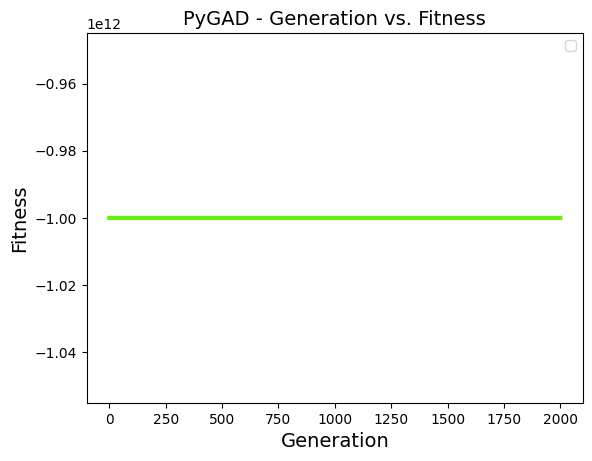

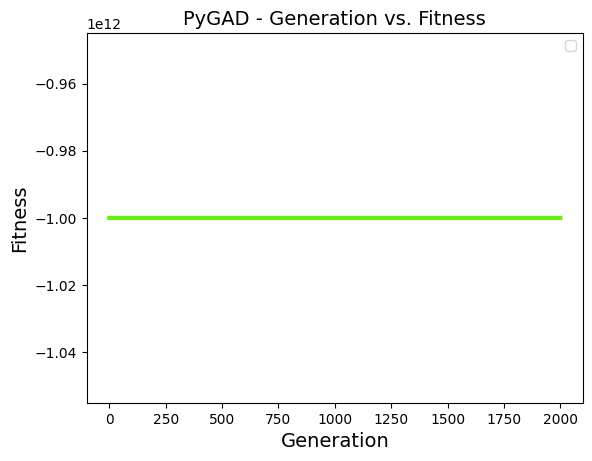

In [110]:
ga_instance.plot_fitness()

In [111]:
with open("graphs/g6.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g6.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)

sequence = [2,4,5]

numAgents = 2
agent_len = 5
genom = [1, 2, 4, 5, 5, 3, 3, 2, 4, 5]

#path(genom, numAgents, agent_len)


6
   A  B  w
0  1  2  5
1  1  3  2
2  1  5  2
3  2  4  2
4  3  1  2
5  3  2  3
6  4  5  1
7  6  5  3


In [112]:
# [   genom_agent1   |   genom_agent2   |   genom_agent3   ]
k = 2
m = 3
agent_len = n*k
numAgents = m
init_pop = creating_init_pop(k, agent_len, numAgents)

gene_space = [i for i in range(1, n+1)]

#print(init_pop)

ga_instance = pygad.GA(fitness_func=fitness_fun3,
                       num_generations=1000,
                       num_parents_mating=5,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(agent_len * numAgents),
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=crossover_task3,
                       mutation_type=mutation_task3,
                      )

ga_instance.run()

In [113]:
ga_instance.best_solution()

(array([2, 2, 2, 2, 4, 2, 5, 1, 1, 1, 1, 1, 2, 4, 2, 5, 2, 2, 2, 1, 1, 1,
        1, 1, 2, 2, 4, 2, 5, 2, 2, 2, 1, 1, 1, 1]),
 np.float64(-1000000000000.0),
 np.int64(0))

In [114]:
with open("graphs/g3.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g3.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)

12
     A   B  w
0    1   4  7
1    1   7  9
2    1   9  4
3    1  11  4
4    2   1  3
..  ..  .. ..
66  12   1  2
67  12   6  3
68  12   9  3
69  12  10  4
70  12  11  7

[71 rows x 3 columns]


In [135]:
sequence = [1, 4, 5, 9, 12]

k = 1
m = 3
agent_len = n*k
numAgents = m
init_pop = creating_init_pop(k, agent_len, numAgents)

gene_space = [i for i in range(1, n+1)]

#print(init_pop)

ga_instance = pygad.GA(fitness_func=fitness_fun3,
                       num_generations=3000,
                       num_parents_mating=10,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(agent_len * numAgents),
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=crossover_task3,
                       mutation_type=mutation_task3,
                      )

ga_instance.run()

In [134]:
ga_instance.best_solution()

(array([ 1,  1,  1,  4,  5,  9,  1,  1,  1,  1,  1, 12,  1,  1,  1,  1,  4,
         5,  1,  1,  9,  1,  1, 12,  1,  1,  1,  1,  1,  1,  4,  5,  1,  1,
         9, 12]),
 np.float64(-1000000000000.0),
 np.int64(0))

In [ ]:
ga_instance.plot_fitness()